In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import random 

from collections import namedtuple, deque 

import gym
from gym import spaces
from tqdm.notebook import tqdm


import matplotlib.pyplot as plt

import time

In [2]:
# Q_Network frame
class QNetwork(nn.Module):

    def __init__(self, state_size,action_size, lay1_size=32, lay2_size=64, lay3_size = 128):
        super(QNetwork,self).__init__() 
        self.fc1= nn.Linear(state_size,lay1_size)
        self.fc2 = nn.Linear(lay1_size,lay2_size)
        self.fc3 = nn.Linear(lay2_size,lay3_size)
        self.fc4 = nn.Linear(lay3_size, action_size)
        
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [3]:
#Replay buffer
class ReplayBuffer:

    def __init__(self, state_size, pack_size, action_size, buffer_size, batch_size):
        self.action_size = action_size
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.state_size = state_size
        self.pack_size = pack_size
        
        self.buffer_states = np.zeros((buffer_size, state_size*pack_size))
        self.buffer_actions = np.zeros(buffer_size)
        self.buffer_rewards = np.zeros(buffer_size)
        self.buffer_next_states = np.zeros((buffer_size, state_size*pack_size))
        self.buffer_dones = np.zeros(buffer_size)
        #self.buffer = np.zeros((buffer_size, 5))

        self.len = 0

    def append(self,state, action, reward, next_state, done):
        #print(f"""
        #    state: {state}
        #    action: {action}
        #    reward: {reward}
        #    next_state: {next_state}
        #    done: {done}
        #""")
        
        self.buffer_states[self.len] = state
        self.buffer_actions[self.len] = action
        self.buffer_rewards[self.len] = reward
        self.buffer_next_states[self.len] = next_state
        self.buffer_dones[self.len] = done
        
        #self.buffer[self.len] = [state, action, reward, next_state, done]
        self.len += 1
        if self.len >= self.buffer_size:
            self.len = 0
        
    def sample(self):
        experiences = np.random.choice(range(self.len),size=self.batch_size,replace = False)
        states = np.zeros((self.buffer_size, self.state_size*self.pack_size))
        actions = np.zeros(self.batch_size)
        rewards = np.zeros(self.batch_size)
        next_states = np.zeros((self.buffer_size, self.state_size*self.pack_size))
        dones = np.zeros(self.batch_size)
        for i in range(self.batch_size):
            states[i] = self.buffer_states[experiences[i]]
            actions[i] = self.buffer_actions[experiences[i]]
            rewards[i] = self.buffer_rewards[experiences[i]]
            next_states[i] = self.buffer_next_states[experiences[i]]
            dones[i] = self.buffer_dones[experiences[i]]
        return states, actions, rewards, next_states, dones
    

In [4]:
#general Agent
class Agent():
    
    def __init__(self, state_size, pack_size, action_size, buffer_size, batch_size, gamma, lr, update_step, lay1_size=64, lay2_size=64):
        #initalize the agent. Since this is a general agent, I won't specify the environment inside the agent.
        #Instead, the informatino will synx from the environment. 
        #save the parameters
        self.state_size = state_size
        self.action_size = action_size
        self.update_step = update_step
        self.batch_size = batch_size
        self.gamma = gamma
        self.pack_size = pack_size
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        #initalize lcoal and target Q-network
        self.local = QNetwork(state_size*pack_size, action_size, lay1_size, lay2_size).to(self.device)
        self.target = QNetwork(state_size*pack_size, action_size, lay1_size, lay2_size).to(self.device)
        
        #equal the weights of two networks
        for target_param, local_param in zip(self.target.parameters(),self.local.parameters()):
            target_param.data.copy_(local_param.data)
        
        #setup optimizer for local networks. 
        #The target networks get update from and only from copying parameters from local. so no optimizer for target network. 
        self.optimizer = optim.Adam(self.local.parameters(),lr=lr)
        self.criterion = torch.nn.MSELoss()
        
        #initalize replay buffer
        self.replay_buffer = ReplayBuffer(state_size, pack_size, action_size, buffer_size, batch_size)
        
        #initalize step count
        self.step_count = 0
        
        
    def step(self, state, action, reward, next_state, done):
        #update the step informaiton of the environment and check if agent need to update the weights
        
        #store transition to experience buffer
        self.replay_buffer.append(state, action, reward, next_state, done)

        self.step_count += 1
        
        #if there is enough data for sampling minibatch
        if self.replay_buffer.len > self.batch_size:
            #get the sample
            states, actions, rewards, next_states, dones = self.replay_buffer.sample()
            #if episode terminates at step j+1
            #print(dones)
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                if done.any() == 1:
                    y = rewards
            #otherwise    
                else:
                #evaluate maxa'(Q^(sj+1, a') from target Q-network)
                    self.target.eval()
                    with torch.no_grad():
                        #get the Q-values of s' from both target and primary network
                        Qps = self.target(torch.from_numpy(next_state).float())
                        temp = self.target(torch.from_numpy(next_state).float())
                    self.target.train()
                    #instead of directly picking largest Q-value from the result of target network, DDQN use the index of the largest
                    #Q-value of the result from the primary network. 
                    y = np.array([reward + self.gamma * Qps.cpu().data.numpy()[np.argmax(temp.cpu().data.numpy())]])
                    
        
        #get the orignal expected Q
                    Q = self.local(torch.from_numpy(state).float())
            
                    Y = Q.clone()
                    #print(Y.shape)
                    Y[action.astype(int)] = y[0]
                    #print(Y[action.astype(int)])# = y[0]
        #gradient descent
                    self.optimizer.zero_grad()
                    
                    loss = self.criterion(Q, Y).to(self.device)
                    #print(loss)
                    loss.backward()
                    self.optimizer.step()
#                    for local_param in self.local.parameters():
#                        print(local_param)
#                        break 
                    return loss.item()
                    
                    
        #every C steps reset Q^ = Q
        if self.step_count % self.update_step == 0:
                for target_param, local_param in zip(self.target.parameters(), self.local.parameters()):
                    target_param.data.copy_(local_param.data)        

                
                
    def action(self, state, epsilon = 0):
        #select action upon current epsilon-greedy policy
        
        self.local.eval()
        
        with torch.no_grad():
            action_values = self.local(torch.from_numpy(state).float())
            
        self.local.train()

        if random.random() > epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return np.random.randint(self.action_size)



In [5]:
import rlcard
from rlcard.agents import DQNAgent

In [6]:
env = rlcard.make("blackjack")

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'episode vs. epsilon decay')

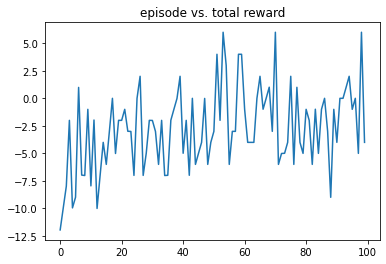

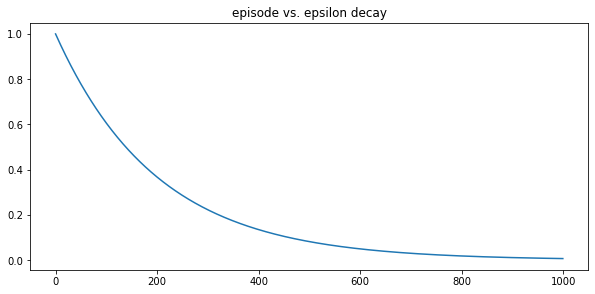

In [7]:
#Agent for env 1
agent = Agent(state_size=2, pack_size = 1, action_size=2, buffer_size = 5000,
                   batch_size=5, gamma = 1, lr = 0.01, update_step = 3)


total_rewards = [] 
E_array = []

eps = 1/0.995
for i in tqdm(range(1000)):
    state, _ = env.reset()
    state = state["obs"]
    final_reward = 0
    final_loss = 0
    eps = eps * 0.995
    E_array.append(eps)
    for t in range(20):
        #pick the action a
        action = agent.action(state,eps)
        
        #a execute the action A and ovserve reward r and next state s'
        next_state,_ = env.step(action)
        next_state = next_state["obs"]
        reward = env.get_payoffs()[0]
        if next_state[0] > 21 or action == 1:
            done = 1
        else:
            done = 0  

        loss = agent.step(state,action,reward,next_state,done)
        state = next_state
        final_reward += 0.99**t*reward
#        final_loss += loss
        if done:
            break
#    final_loss = final_loss/t
    total_rewards.append(final_reward) ## sae the most recent score

#plt.plot(range(200), total_loss)
tr = []
for i in range(100):
    r = 0
    for x in range(10):
        r+=total_rewards[i*10+x]
    tr.append(r)

plt.plot(range(100), tr)
plt.title("episode vs. total reward")
plt.figure(2,figsize = (10,10))
plt.subplot(212)

plt.plot(range(1000), E_array)
plt.title("episode vs. epsilon decay")


In [8]:
total_rewards = [] 
for i in tqdm(range(100)):
    state, _ = env.reset()
    state = state["obs"]
    final_reward = 0
    final_loss = 0
    E_array.append(eps)
    for t in range(20):
        #pick the action a
        action = agent.action(state,0)
        
        #a execute the action A and ovserve reward r and next state s'
        next_state,_ = env.step(action)
        next_state = next_state["obs"]
        reward = env.get_payoffs()[0]
        if next_state[0] > 21 or action == 1:
            done = 1
        else:
            done = 0  

        loss = agent.step(state,action,reward,next_state,done)
        state = next_state
        final_reward += 0.99**t*reward
#        final_loss += loss
        if done:
            break
#    final_loss = final_loss/t
    total_rewards.append(final_reward) ## sae the most recent score
    

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
win = 0
draw = 0
lose = 0

for i in total_rewards:
    if i > 0:
        win += 1
    elif i == 0:
        draw += 1
    else:
        lose += 1

print(f'''
Win rate: {win}%
Draw rate: {draw}%
Lose rate: {lose}%
''')


Win rate: 41%
Draw rate: 3%
Lose rate: 56%

